<img src="assets/process_optimization_featured1.jpg" style="display:block; margin:auto" width=350>

<h1><center>Project: Optimizing Model Prediction</center></h1>

In this project, we aim to optimize the prediction of forest fire damage using the Forest Fires [dataset](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) from the UCI Machine Learning Repository. The dataset contains information on forest fires in the Montesinho Park, Portugal, along with meteorological and environmental variables that potentially influence fire size. The objective is to predict the burned area (area) of the forest, which is highly skewed toward small values and has a long tail of larger fires. To address this, we log-transform the target variable to reduce skewness and improve model performance.

#### Approach
For this project, we'll do a series of data preprocessing steps, including handling missing values, encoding cyclic features (month and day), outlier detection and handling, and standardizing numerical features. Following this, we implement feature selection methods (Forward and Backward Selection) and evaluate several models, including Linear Regression, Ridge Regression, Lasso Regression, and Spline Transformation, using cross-validation.

#### Data
Our data comes from the [Forest Fires](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) dataset from the UCI Machine Learning Repository. This dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage. The feature and target columns are the following:

|Variable Name|	Role|Type|Description|
|----|----|----|----|
|X	|Feature	|Integer	|x-axis spatial coordinate within the Montesinho park map: 1 to 9|		
|Y	|Feature	|Integer	|y-axis spatial coordinate within the Montesinho park map: 2 to 9|	
|month	|Feature	|Categorical	|month of the year: 'jan' to 'dec'|
|day	|Feature	|Categorical	|day of the week: 'mon' to 'sun'|
|FFMC (Fine Fuel Moisture Code)	|Feature	|Continuous	|FFMC index from the FWI system: 18.7 to 96.20|		
|DMC (Duff Moisture Code)	|Feature	|Integer	|DMC index from the FWI system: 1.1 to 291.3|
|DC	(Drought Code) |Feature	|Continuous	|DC index from the FWI system: 7.9 to 860.6|	
|ISI (Initial Spread Index)|Feature	|Continuous	|ISI index from the FWI system: 0.0 to 56.10|
|temp	|Feature	|Continuous |temperature: 2.2 to 33.30	Celsius degrees|
|RH|	Feature	|Integer	|relative humidity: 15.0 to 100	%|
|wind	|Feature	|Continuous	|wind speed: 0.40 to 9.40	km/h|
|rain	|Feature	|Integer	|outside rain: 0.0 to 6.4	mm/m2|
|area	|Target	|Integer	|the burned area of the forest: 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).|

*This project was completed as part of the Data Science Career Path offered by dataquest.io.*

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn for model building, evaluation, and preprocessing
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

In [2]:
# Load fires df
fire = pd.read_csv('fires.csv')

# Drop column "Unnamed: 0"
fire.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
# Set reference features + drop na values
fire_reference = fire[["wind", "temp", "area"]].dropna()
reference_X = fire_reference[["wind", "temp"]]

# Instantiate the reference model
reference = LinearRegression()

#### Initial EDA

In [4]:
# Check fire df 
fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [5]:
# Check fire df information
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    469 non-null    float64
 5   DMC     496 non-null    float64
 6   DC      474 non-null    float64
 7   ISI     515 non-null    float64
 8   temp    496 non-null    float64
 9   RH      487 non-null    float64
 10  wind    482 non-null    float64
 11  rain    485 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 52.6+ KB


In [6]:
# Check fire df information
fire.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,469.000000,496.000000,474.000000,515.000000,496.000000,487.000000,482.000000,485.000000,517.000000
mean,4.669246,4.299807,90.580384,111.195363,550.673418,9.018835,18.884677,44.381930,4.021784,0.023093,12.847292
std,2.313778,1.229900,5.698137,64.008450,246.061309,4.564890,5.748318,16.180372,1.794460,0.305532,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,70.800000,441.200000,6.450000,15.475000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.800000,141.575000,713.900000,10.750000,22.725000,53.500000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


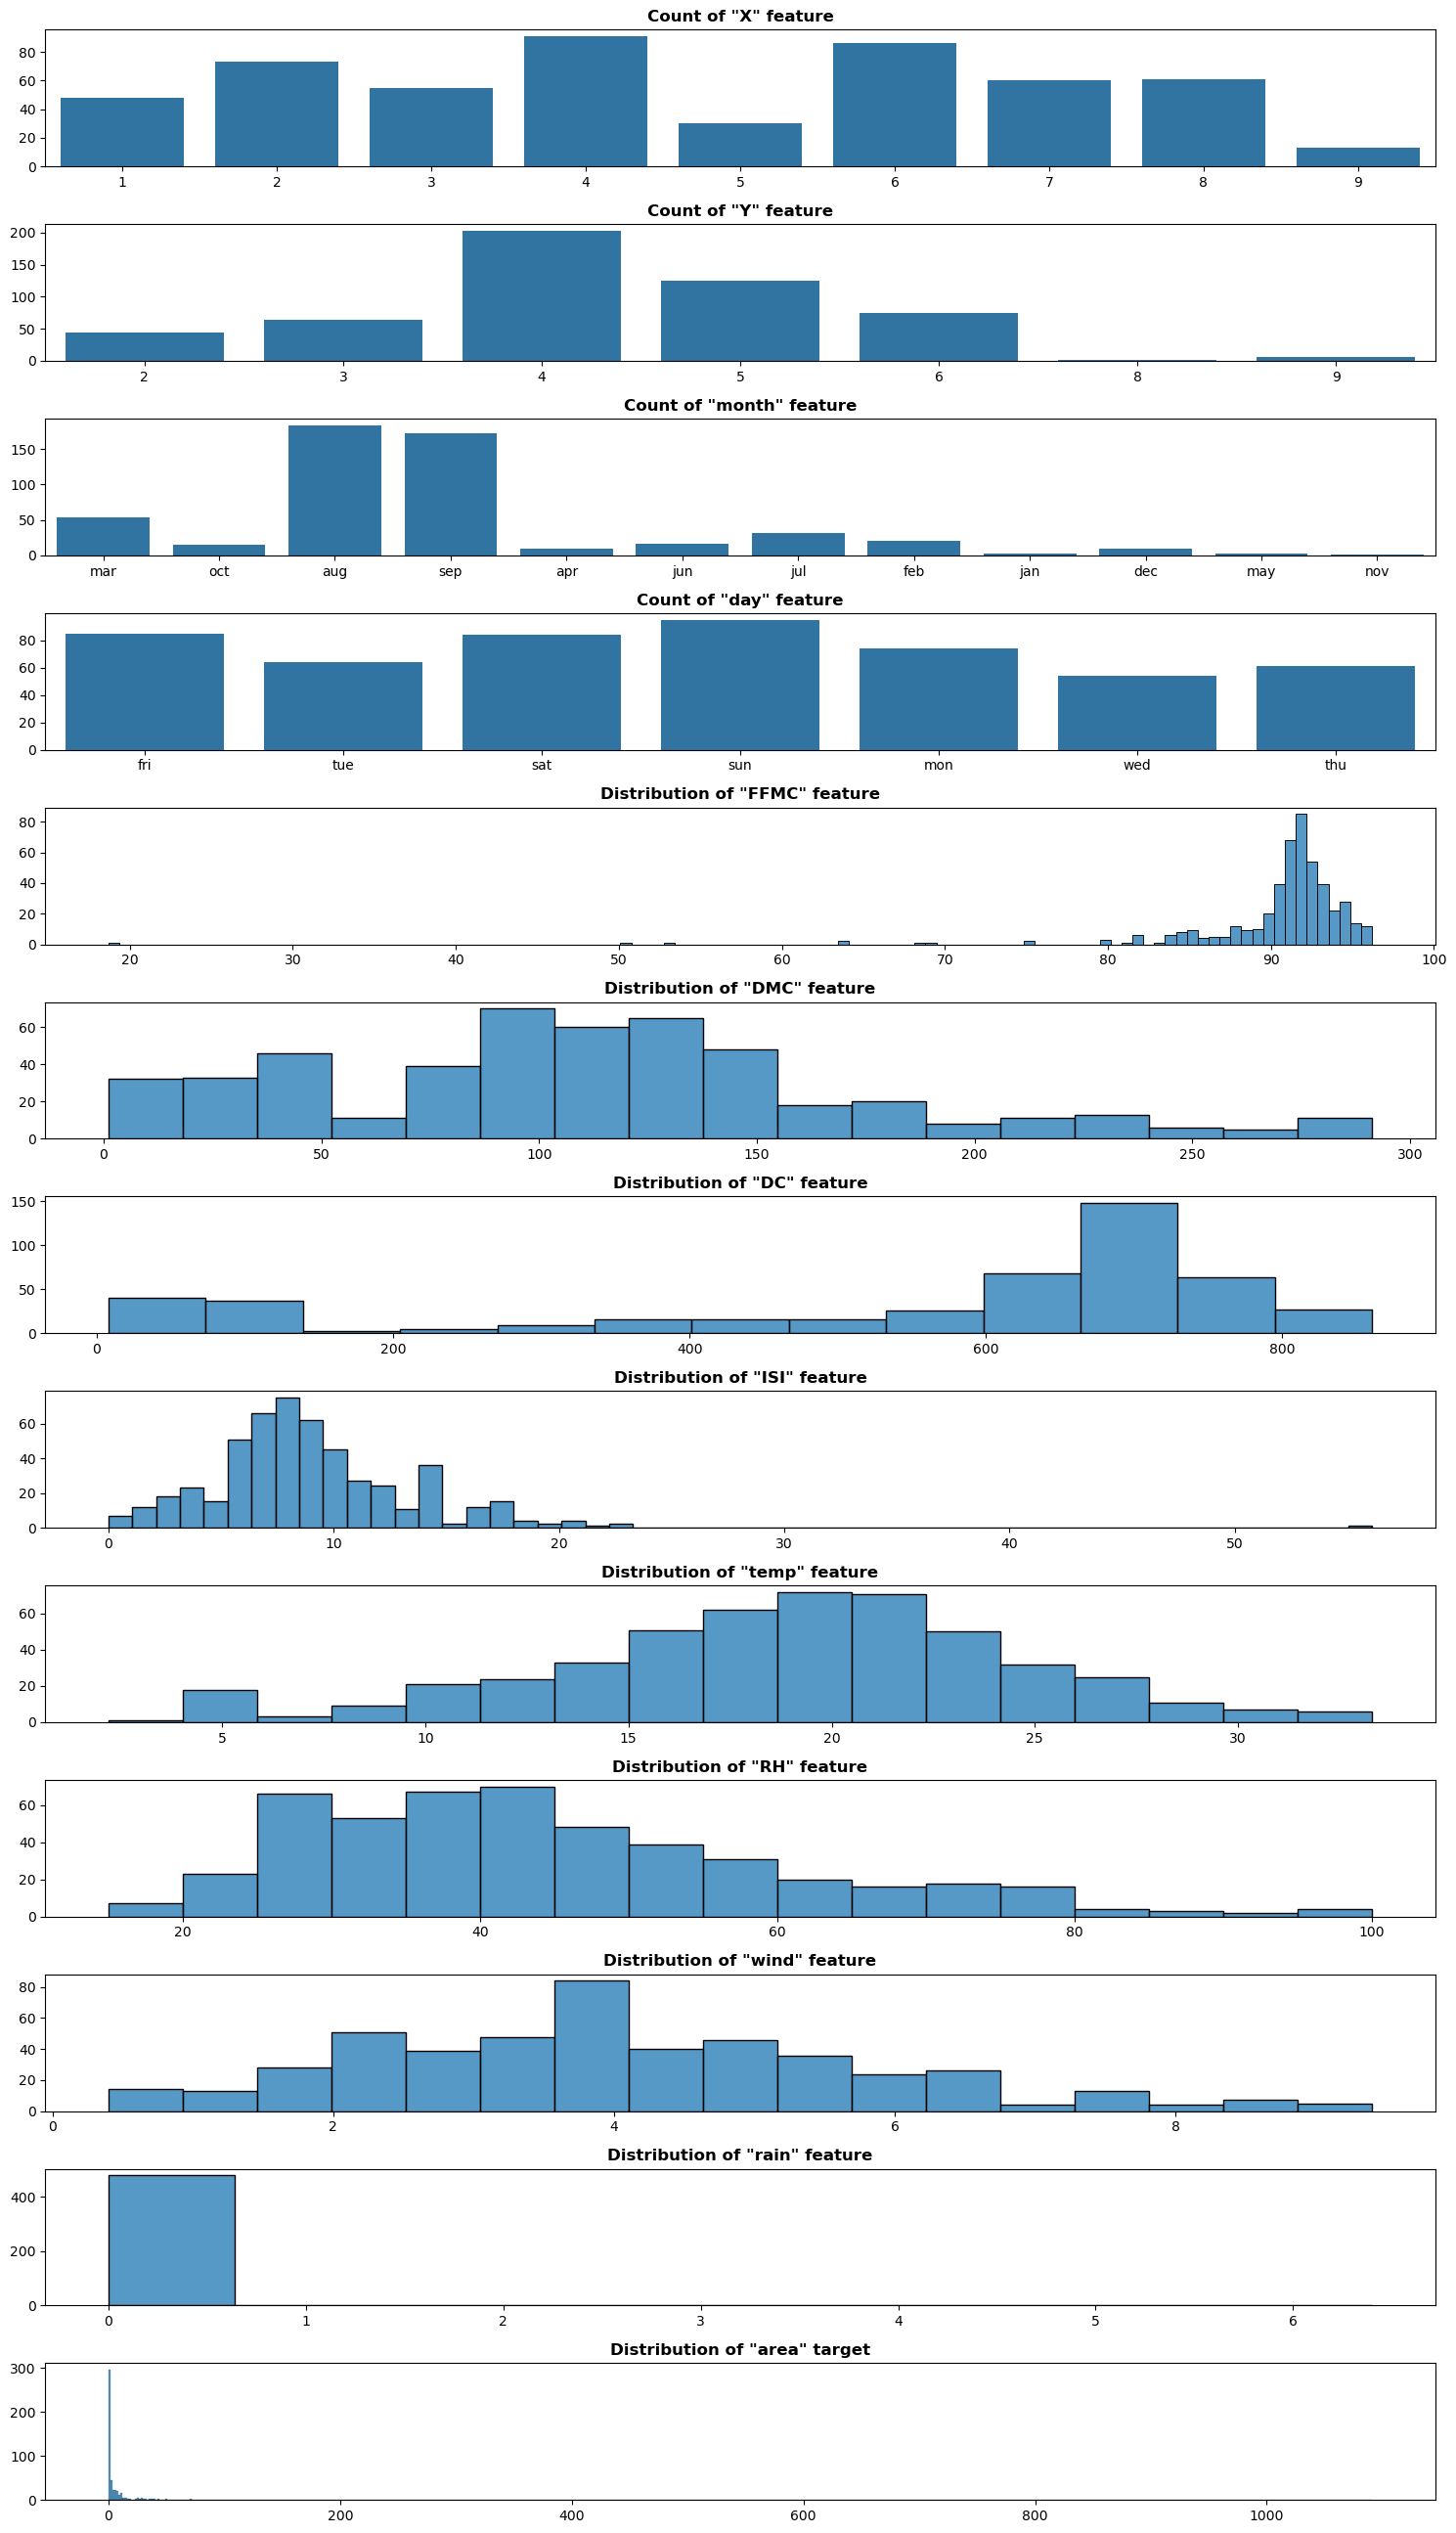

In [7]:
# Visualize feature and target columns
# Create subplots dynamically based on the number of columns
num_columns = len(fire.columns)
fig, axs = plt.subplots(num_columns, figsize=(15, num_columns * 2))

# Iterate over each column and plot them
for i, column in enumerate(fire.columns):
    if fire[column].dtypes == 'object' or fire[column].dtypes == 'int64':
        sns.countplot(data=fire, x=column, ax=axs[i])
        axs[i].set_title(f'Count of "{column}" feature', weight='bold')
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
    else:
        sns.histplot(data=fire, x=column, ax=axs[i])
        if column == 'area':
            axs[i].set_title(f'Distribution of "{column}" target', weight='bold')
            axs[i].set_xlabel('')
            axs[i].set_ylabel('')
        else:
            axs[i].set_title(f'Distribution of "{column}" feature', weight='bold')
            axs[i].set_xlabel('')
            axs[i].set_ylabel('')
    
# Remove legends from plots
for i, ax in enumerate(axs.flat):
    if i > 0 and i < 13:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

# Use tight layout for visualization
plt.tight_layout()
plt.show()

#### Features vs. Area (Target)

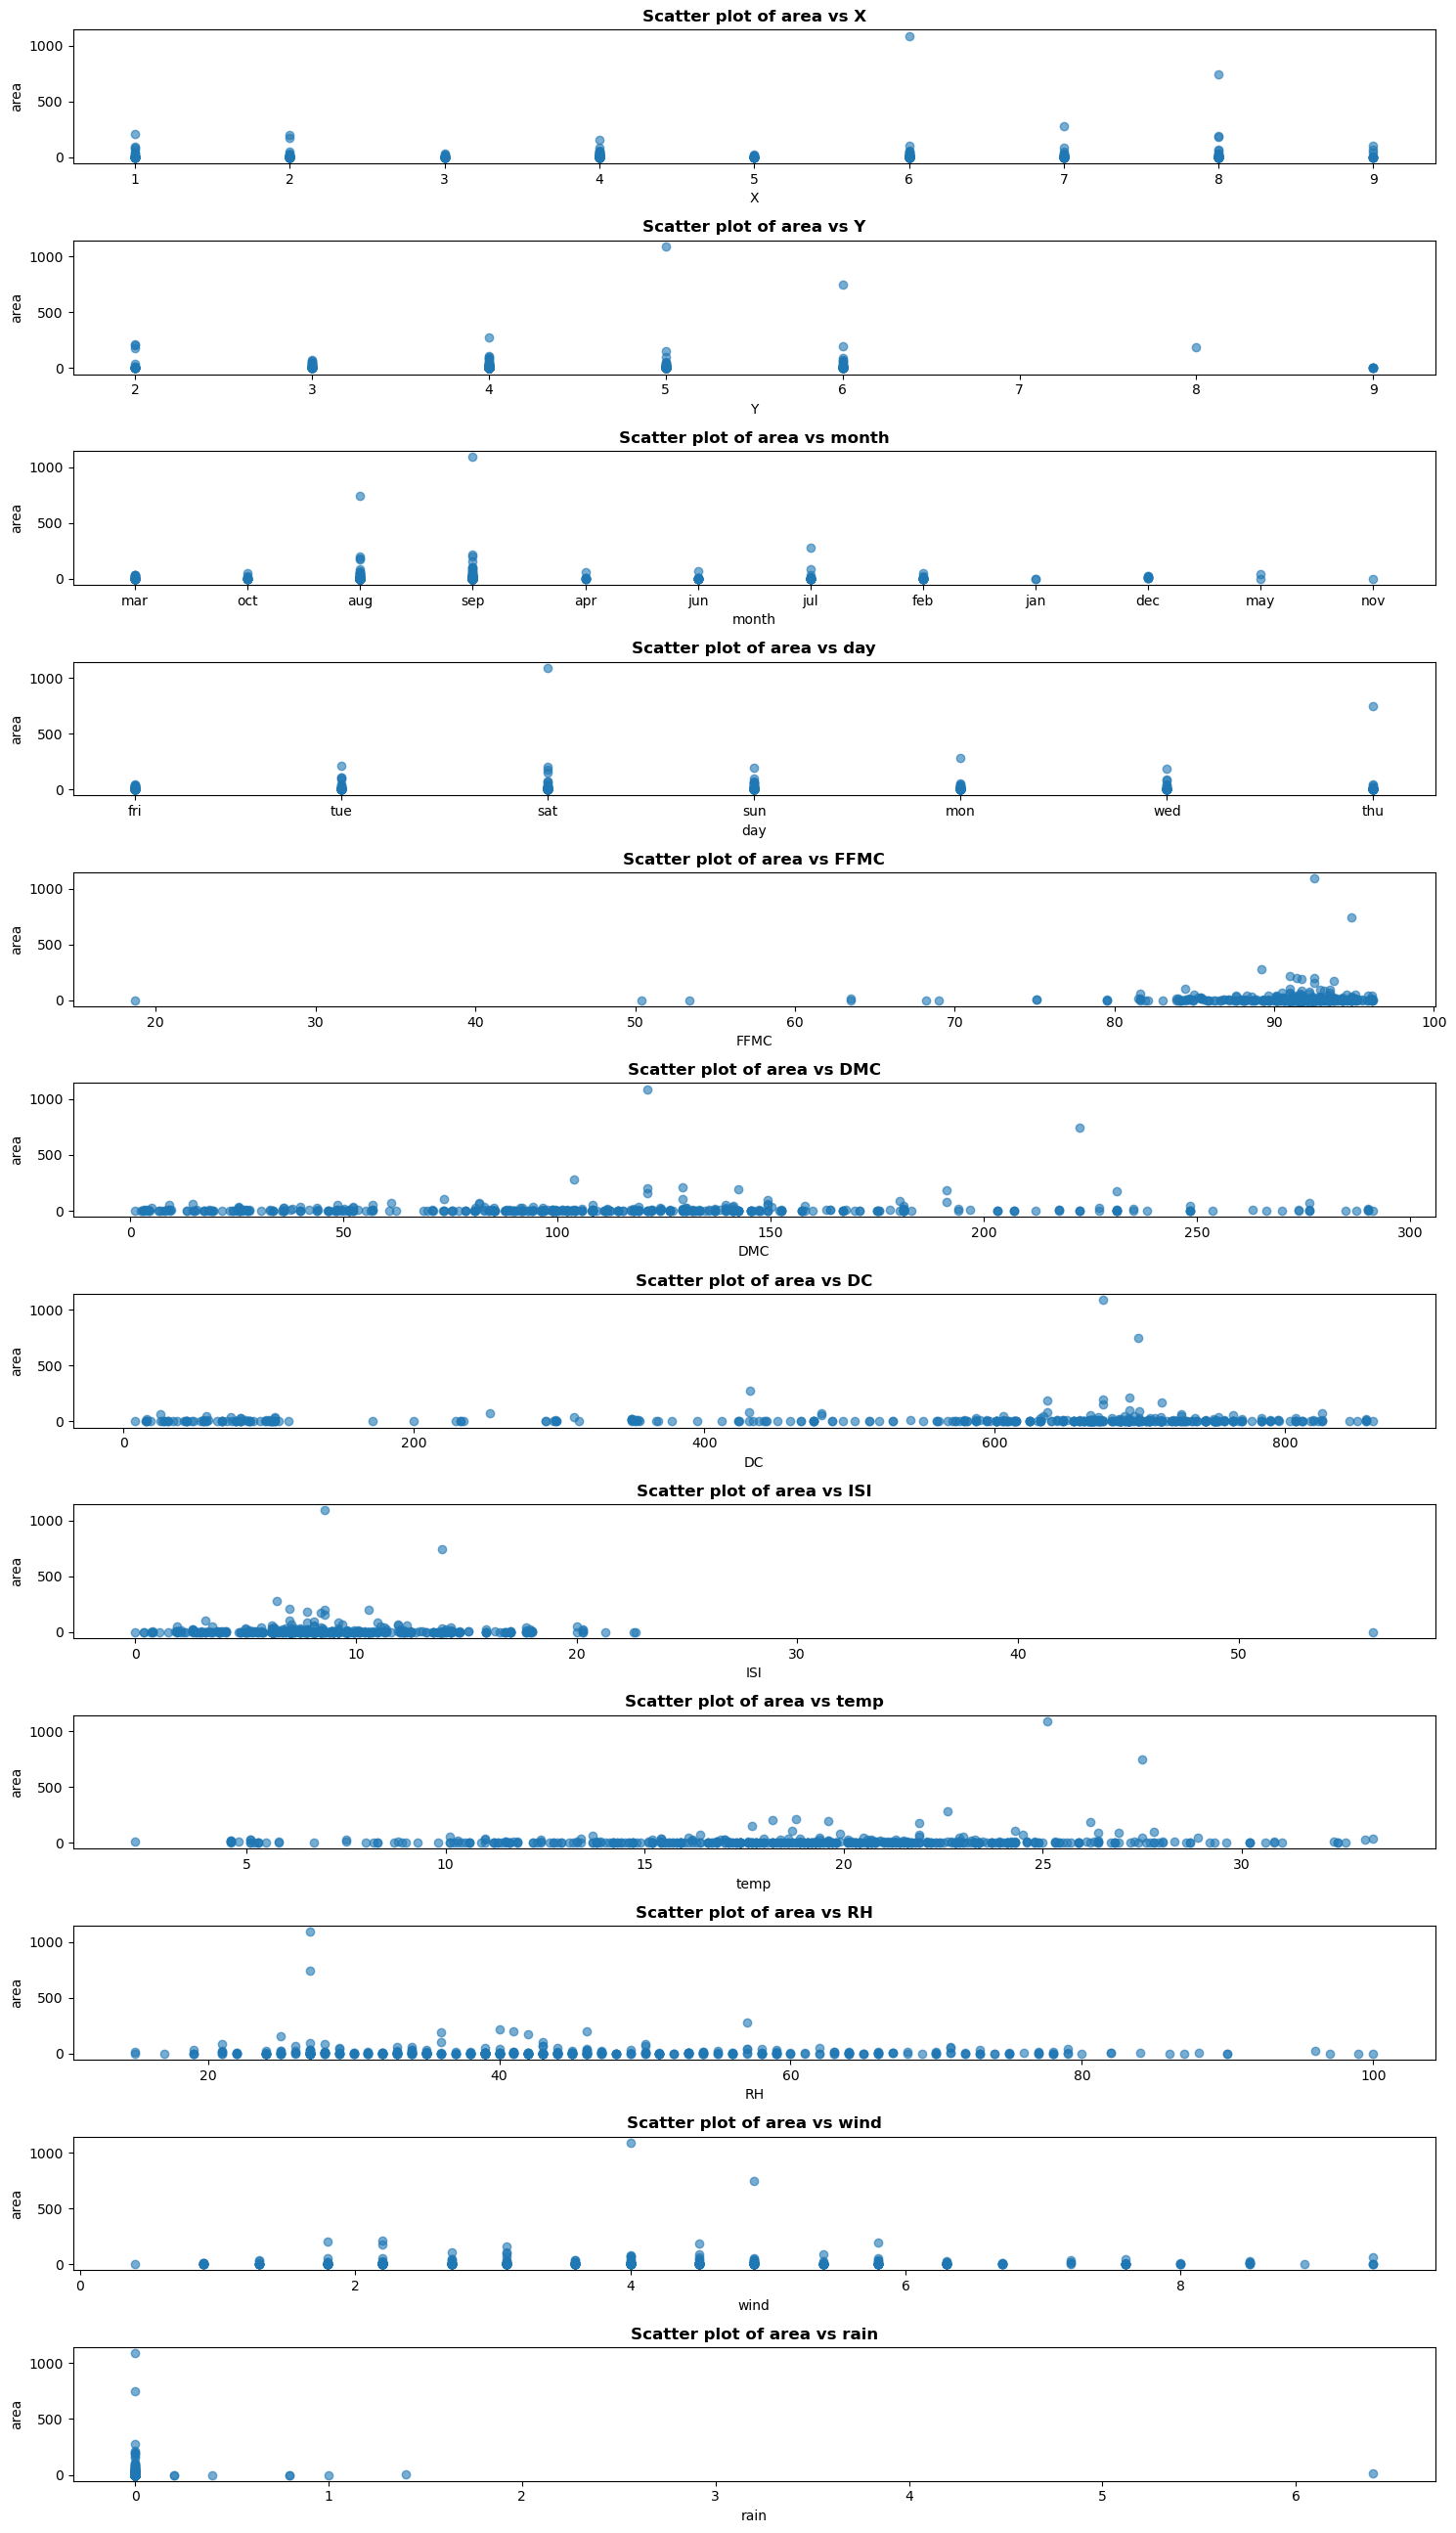

In [8]:
# Visualize feature by target column
num_cols = len(fire.columns)

# Create subplots for original 'area'
fig, axs = plt.subplots(num_cols-1, figsize=(15, 2 * num_cols))
for i, column in enumerate(fire.columns):
    if column != 'area':
        axs[i].scatter(fire[column], fire['area'], alpha=0.6)
        axs[i].set_title(f'Scatter plot of area vs {column}', weight='bold')
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('area')

plt.tight_layout()
plt.show()

#### Brief Interpretation

**Features X and Y (Spatial Coordinates)**

- The scatter plots for `X` and `Y` (spatial coordinates within the park) show a fairly uniform distribution of points along their respective axes. There are no clear trends or relationships between the spatial coordinates and the burned area (area). This might indicate that the location alone (without other contextual data) is not strongly correlated with the size of the fire area.

**Features month and day**

- Both `month` and `day` show discrete clusters of points along the x-axis due to their categorical nature. There is no clear pattern between these temporal features and area in the current plots.

**Features FFMC, DMC, DC, and ISI (Fire Weather Indices)**

- `FFMC` (Fine Fuel Moisture Code) shows a slight pattern where higher values are more densely populated, but no clear correlation with area is evident. Most high FFMC values cluster around small area values.
- `DMC` (Duff Moisture Code) and DC (Drought Code) both have scattered points with no clear trend, although there might be potential patterns that require further exploration (e.g., non-linear relationships).
- `ISI` (Initial Spread Index) shows a dense cluster of points at lower ISI values, suggesting most fires have a low spread index, but no strong linear correlation with area.

**Features temp, RH, wind, rain (Weather Features)**

- `temp` (Temperature) shows some density around small fire areas (area), but no clear linear relationship.
- `RH` (Relative Humidity) shows most points clustered at higher humidity values but, again, no strong correlation with area.
- `wind` (Wind Speed) has most data points concentrated at low wind speeds, with no apparent relationship to area.
- `rain` (Rainfall) has most points at zero or low values, which is expected as rainfall might not be a frequent occurrence in the dataset. No clear trend with area.


**Conclusion**

Most features do not show a clear linear relationship with the target variable `area`. This indicates that either the relationships are non-linear, weak, or require further preprocessing (e.g., log transformation) to uncover patterns. Lets look deeper in the data.

#### Data Preprocessing and Feature Engineering

**1. Examine the Distribution of the Outcome Column (area)**

The distribution of the area target (outcome) column appears to be highly skewed (right-skewed) with many values close to 0 and a long tail of higher values. Therefore we'll apply a logarithmic transformation to reduce skewness and normalize the distribution. Since the area column contains 0 values, I'll use log(area + 1) to avoid log(0) issues.

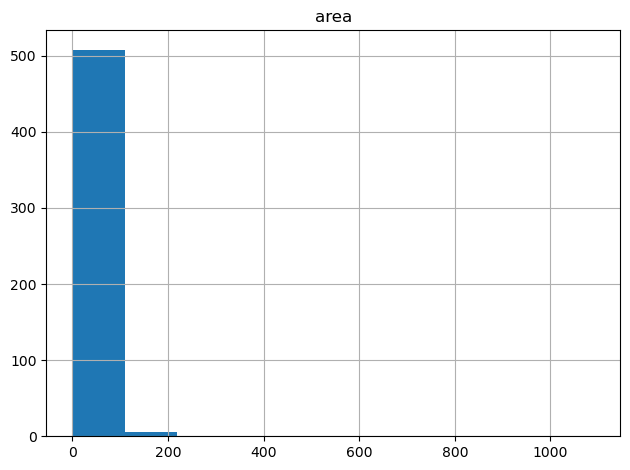

In [9]:
# Create histogram of target
fire.hist('area')

# Use tight layout for visualization
plt.tight_layout()
plt.show()

The histogram of the original area shows a right-skewed distribution, with most fire areas close to zero and a long tail of larger values.

In [10]:
# Log transformation for the 'area' column
fire['area_log'] = fire['area'].apply(lambda x: np.log(x + 1))

## Alternative approach, instead of using "np.log" we can use "np.log1p" to handle zero values safely
#fires_df['area_log'] = np.log1p(fires_df['area'])

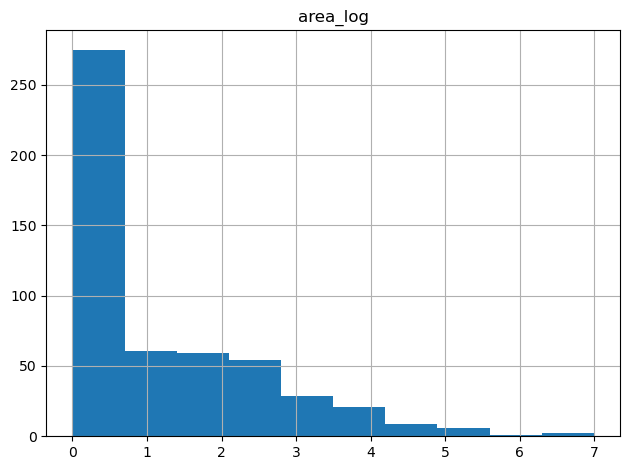

In [11]:
# Create histogram of log target
fire.hist('area_log')

# Use tight layout for visualization
plt.tight_layout()
plt.show()

After applying the log transformation, the `area_log` histogram is more normally distributed. This transformation helps stabilize variance and reduce skewness, making relationships with features potentially easier to detect.

**2. Handling month and day Columns**

The month and day columns provide temporal information. They can be useful features if transformed correctly. Instead of using them as categorical variables directly, which may not provide meaningful information, I will convert month and day into numerical features. Encode month using a cyclical transformation (sine and cosine) to capture seasonality. Similarly, encode day using a cyclical transformation to capture weekly patterns.

Converting month and day into sine and cosine values is a technique known as [cyclical encoding](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning). This technique is useful when dealing with cyclic features like month of the year or day of the week because these features have a natural cyclic order (e.g., January follows December, and Monday follows Sunday). 

**Formulas**

$$\text{sin}(x) = \sin\left( \frac{2 \pi \cdot x}{n} \right)$$

$$\text{cos}(x) = \cos\left( \frac{2 \pi \cdot x}{n} \right)$$

For the `month` variable:

$$\text{month\_sin} = \sin\left( \frac{2 \pi \cdot \text{month}}{12} \right)$$

$$\text{month\_cos} = \cos\left( \frac{2 \pi \cdot \text{month}}{12} \right)$$

For the `day` variable:

$$\text{day\_sin} = \sin\left( \frac{2 \pi \cdot \text{day}}{7} \right)$$

$$\text{day\_cos} = \cos\left( \frac{2 \pi \cdot \text{day}}{7} \right)$$

In [12]:
# Convert 'month' to numerical format using cyclical transformation
fire['month_sin'] = np.sin(2 * np.pi * fire['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 
                                                          'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}) / 12)
fire['month_cos'] = np.cos(2 * np.pi * fire['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 
                                                          'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}) / 12)

# Convert 'day' to numerical format using cyclical transformation
fire['day_sin'] = np.sin(2 * np.pi * fire['day'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 
                                                      'fri': 5, 'sat': 6, 'sun': 7}) / 7)
fire['day_cos'] = np.cos(2 * np.pi * fire['day'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 
                                                      'fri': 5, 'sat': 6, 'sun': 7}) / 7)

# Drop the original 'month' and 'day' columns
fire.drop(columns=['month', 'day'], inplace=True)

print(fire[['month_sin', 'month_cos', 'day_sin', 'day_cos']])

     month_sin     month_cos       day_sin   day_cos
0     1.000000  6.123234e-17 -9.749279e-01 -0.222521
1    -0.866025  5.000000e-01  9.749279e-01 -0.222521
2    -0.866025  5.000000e-01 -7.818315e-01  0.623490
3     1.000000  6.123234e-17 -9.749279e-01 -0.222521
4     1.000000  6.123234e-17 -2.449294e-16  1.000000
..         ...           ...           ...       ...
512  -0.866025 -5.000000e-01 -2.449294e-16  1.000000
513  -0.866025 -5.000000e-01 -2.449294e-16  1.000000
514  -0.866025 -5.000000e-01 -2.449294e-16  1.000000
515  -0.866025 -5.000000e-01 -7.818315e-01  0.623490
516  -0.500000  8.660254e-01  9.749279e-01 -0.222521

[517 rows x 4 columns]


In [13]:
# Check info of df
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          517 non-null    int64  
 1   Y          517 non-null    int64  
 2   FFMC       469 non-null    float64
 3   DMC        496 non-null    float64
 4   DC         474 non-null    float64
 5   ISI        515 non-null    float64
 6   temp       496 non-null    float64
 7   RH         487 non-null    float64
 8   wind       482 non-null    float64
 9   rain       485 non-null    float64
 10  area       517 non-null    float64
 11  area_log   517 non-null    float64
 12  month_sin  517 non-null    float64
 13  month_cos  517 non-null    float64
 14  day_sin    517 non-null    float64
 15  day_cos    517 non-null    float64
dtypes: float64(14), int64(2)
memory usage: 64.8 KB


**3. Imputation of Missing Values**

After the transformation of the `day` and `month` columns, the dataframe only includes numerical features. For imputation I'll use the KNNImputer, which only uses the observations it counts as neighbors and then calculates the mean (or other) to fill the NaN.

In [14]:
# Drop target value, create feature df
features = fire.drop(columns=['area_log', 'area'])

# Impute missing values with mean of neighbors with KNNImpuiter
imputer = KNNImputer(missing_values=np.nan, n_neighbors=3)
imputed_df = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

In [15]:
# Check new imputed_df 
imputed_df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,day_sin,day_cos
0,7.0,5.0,86.2,26.2,94.300000,5.1,16.6,51.0,6.700000,0.0,1.000000,6.123234e-17,-9.749279e-01,-0.222521
1,7.0,4.0,90.6,63.6,669.100000,6.7,18.0,33.0,0.900000,0.0,-0.866025,5.000000e-01,9.749279e-01,-0.222521
2,7.0,4.0,90.6,43.7,470.833333,6.7,14.6,33.0,1.300000,0.0,-0.866025,5.000000e-01,-7.818315e-01,0.623490
3,8.0,6.0,91.7,33.3,77.500000,9.0,8.3,97.0,4.000000,0.2,1.000000,6.123234e-17,-9.749279e-01,-0.222521
4,8.0,6.0,89.3,51.3,102.200000,9.6,11.4,99.0,4.333333,0.0,1.000000,6.123234e-17,-2.449294e-16,1.000000


In [16]:
# Check feature df values
imputed_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,day_sin,day_cos
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,5.170000e+02,5.170000e+02,517.000000
mean,4.669246,4.299807,90.651838,110.888846,545.058414,9.016054,18.912315,44.272083,4.018956,0.021663,-0.541053,-2.202066e-01,-6.059765e-02,0.109757
std,2.313778,1.229900,5.492766,63.454479,244.677262,4.556973,5.766558,15.871534,1.772747,0.295959,0.702852,4.074885e-01,7.070413e-01,0.697339
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,-1.000000,-1.000000e+00,-9.749279e-01,-0.900969
25%,3.000000,4.000000,90.300000,70.800000,442.100000,6.500000,15.600000,33.000000,2.700000,0.000000,-1.000000,-5.000000e-01,-7.818315e-01,-0.222521
50%,4.000000,4.000000,91.600000,108.300000,658.200000,8.400000,19.300000,42.000000,4.000000,0.000000,-0.866025,-1.836970e-16,-2.449294e-16,-0.222521
75%,7.000000,5.000000,92.800000,141.300000,706.800000,10.700000,22.800000,53.000000,4.900000,0.000000,-0.500000,-1.836970e-16,7.818315e-01,0.623490
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1.000000,1.000000e+00,9.749279e-01,1.000000


In [17]:
# Check feature df for missing values
imputed_df.isna().sum()

X            0
Y            0
FFMC         0
DMC          0
DC           0
ISI          0
temp         0
RH           0
wind         0
rain         0
month_sin    0
month_cos    0
day_sin      0
day_cos      0
dtype: int64

**4. Outlier Detection and Handling**

I'll visually inspect potential outliers in features such as FFMC, DMC, DC, etc. Based on the visual inspection, I will decide whether to remove or cap outliers. Outliers could be handled using methods like capping at the 99th percentile or removing them altogether, depending on their impact on the model's performance. Lets first look at the boxplots for our features.

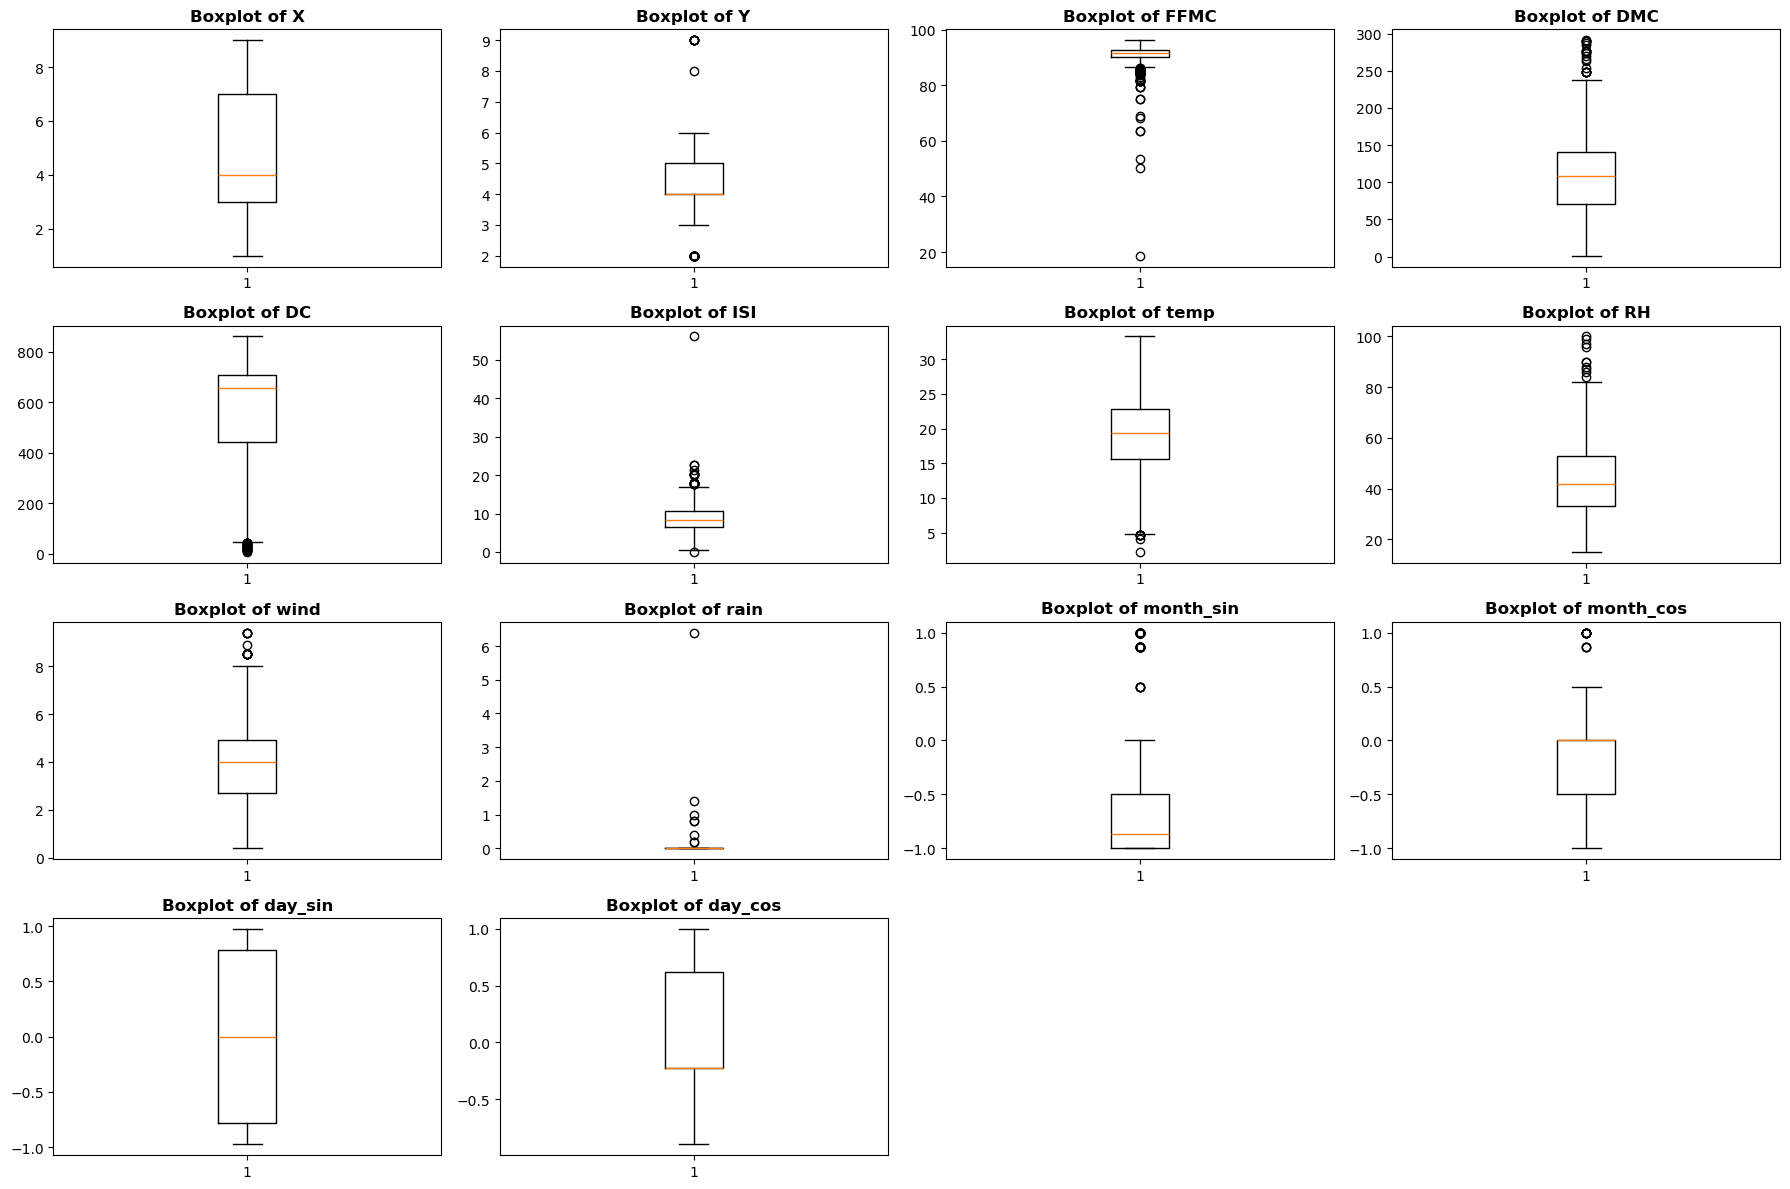

In [18]:
# Plot boxplots for each numerical feature
fig, axes = plt.subplots(4, 4, figsize=(18, 12))  # 4x4 grid for up to 16 plots
axes = axes.flatten()  # Flatten the axes for easy iteration

# Loop through columns and plot each as a boxplot
for i, column in enumerate(imputed_df.columns):
    axes[i].boxplot(imputed_df[column], vert=True)  # Show boxplots vertically
    axes[i].set_title(f'Boxplot of {column}', weight='bold')
    axes[i].set_xlabel('')

# # Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The dots indicate that there are outliers in the specific feature column, let's examine the number of outliers in each of the columns using the boxplot method. 

In [19]:
# Loop through features and calculate outliers using interquartile range (upper + lower bound)
for col in imputed_df:
    mhv_quartiles = np.percentile(imputed_df[col], [25, 50, 75])
    mhv_iqr = mhv_quartiles[2] - mhv_quartiles[0]
    lower_bound = mhv_quartiles[0] - (1.5 * mhv_iqr)
    upper_bound = mhv_quartiles[2] + (1.5 * mhv_iqr)
    mhv_num_outliers = sum((imputed_df[col] > upper_bound) | (imputed_df[col] < lower_bound))

    print(f'The {col} column does have {mhv_num_outliers} outliers, using the boxplot method')

The X column does have 0 outliers, using the boxplot method
The Y column does have 51 outliers, using the boxplot method
The FFMC column does have 53 outliers, using the boxplot method
The DMC column does have 22 outliers, using the boxplot method
The DC column does have 25 outliers, using the boxplot method
The ISI column does have 23 outliers, using the boxplot method
The temp column does have 8 outliers, using the boxplot method
The RH column does have 10 outliers, using the boxplot method
The wind column does have 13 outliers, using the boxplot method
The rain column does have 8 outliers, using the boxplot method
The month_sin column does have 87 outliers, using the boxplot method
The month_cos column does have 12 outliers, using the boxplot method
The day_sin column does have 0 outliers, using the boxplot method
The day_cos column does have 0 outliers, using the boxplot method


Based on the results of the boxplot method, we identified the following columns as relevant for capping:

- `FFMC`: FFMC has several lower outliers below the minimum whisker, and one significant outlier.
- `DMC`: There are several upper outliers beyond the third quartile.
- `DC`: This feature has several low-value outliers below the lower whisker.
- `ISI`: Several outliers are visible on both the lower and upper ends.
- `temp`: The temperature feature shows outliers on lower ends.
- `wind`: Wind speed shows a few upper outliers.
- `rain`: Rain has many outliers near zero, indicating that most observations have little to no rain and a few observations with non-zero values are considered outliers.

In [20]:
# Define a function to cap values at both ends (1st and 99th percentiles)
def cap_outliers(df, column):
    lower_limit = df[column].quantile(0.01)
    upper_limit = df[column].quantile(0.99)
    df[column] = np.where(df[column] < lower_limit, lower_limit, df[column])
    df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])

# Apply capping to relevant numerical columns
for column in ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'wind', 'rain']:  # List of columns to cap
    cap_outliers(imputed_df, column)

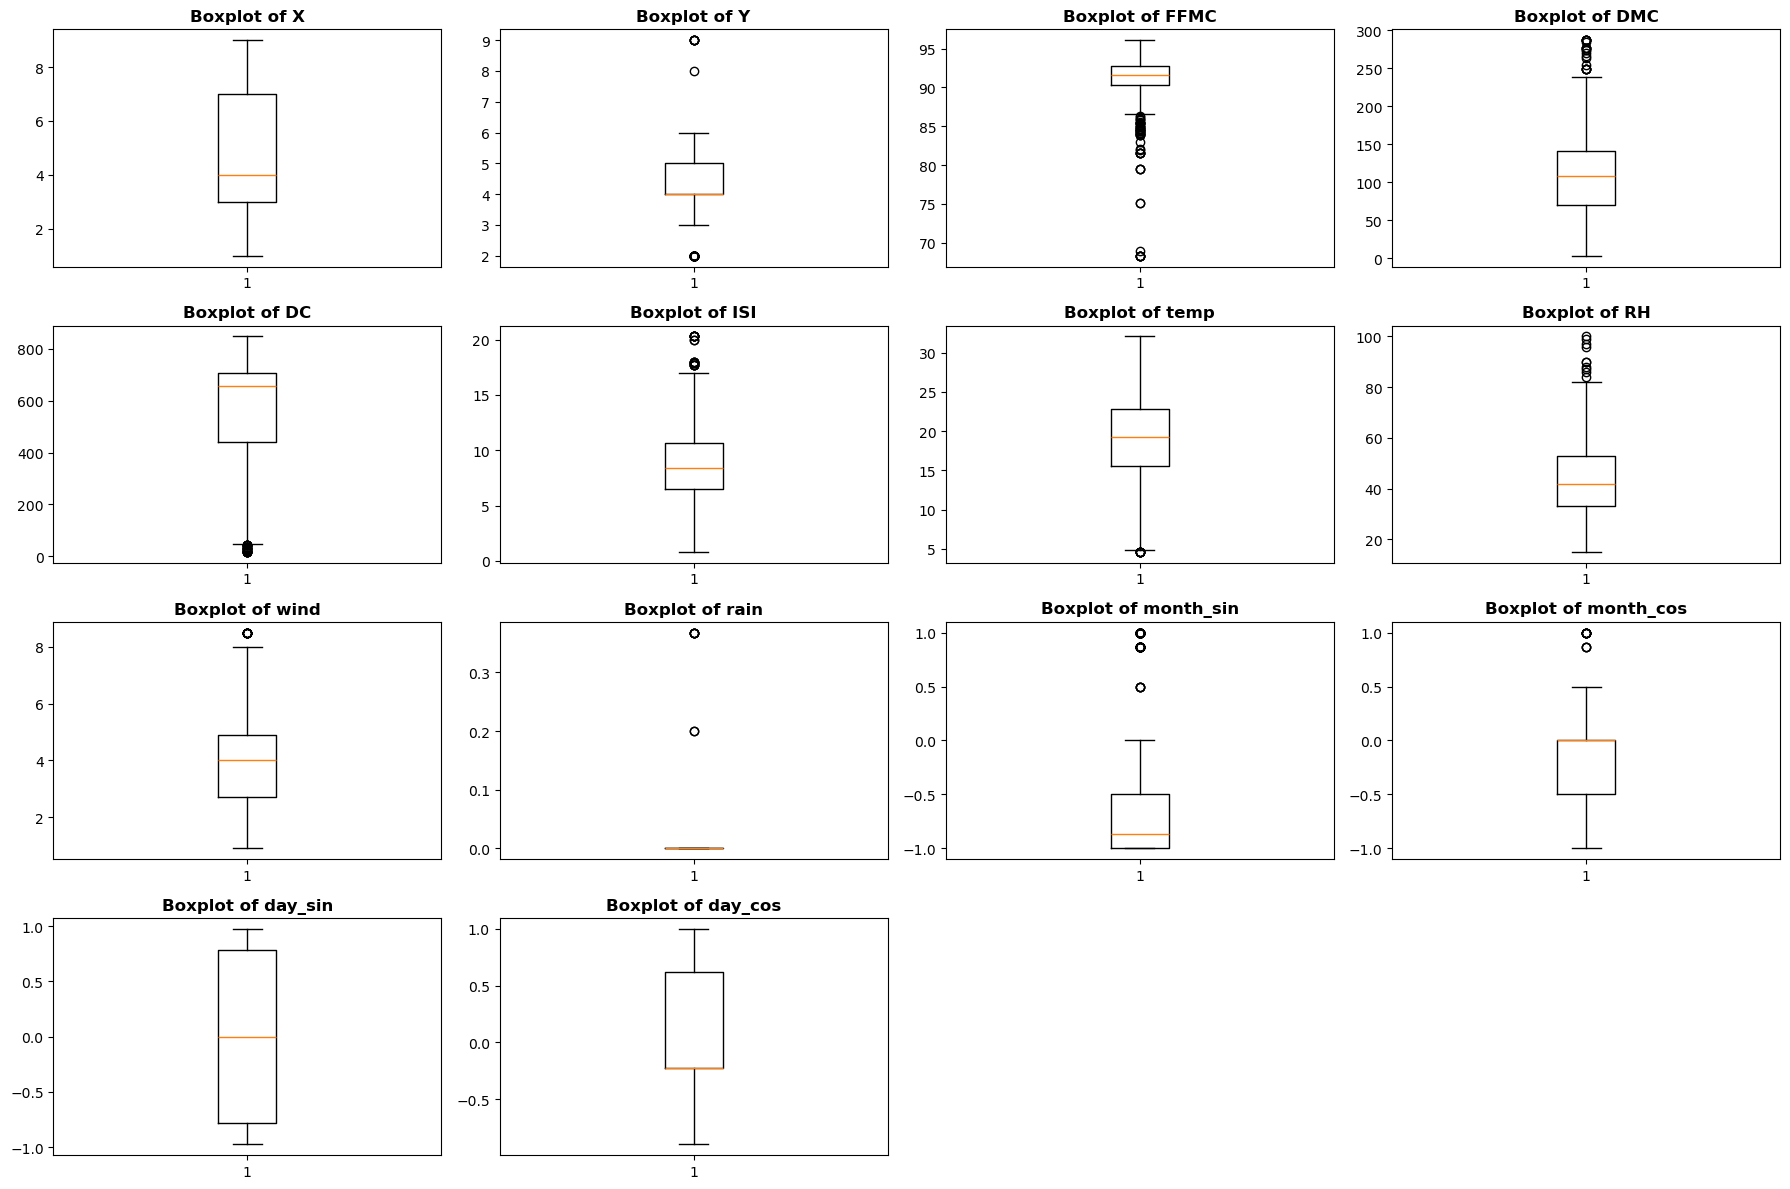

In [21]:
# Plot the capped DataFrame to check the changes
fig, axes = plt.subplots(4, 4, figsize=(18, 12))  # 4x4 grid for up to 16 plots
axes = axes.flatten()  # Flatten the axes for easy iteration

# Loop through columns and plot each as a boxplot
for i, column in enumerate(imputed_df.columns):
    axes[i].boxplot(imputed_df[column], vert=True)  # Show boxplots vertically
    axes[i].set_title(f'Boxplot of {column}', weight='bold')
    axes[i].set_xlabel('')

# # Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

After removing the extreme outliers (values below the 1st percentile and above the 99th percentile) from the specific columns, the distribution of the boxplots has changed. This indicates that the data is now less influenced by extreme values, resulting in a more compact and representative range for the majority of the data points. The absence of these extreme outliers helps in better visualizing the central tendency and spread of the data, improving the interpretability and reliability of the analysis.

**5. Standardization of Features**

Now that the dataset has been inspected for missing values and outliers, we can proceed to standardize it. These standardized values will help for standardization. For most machine learning models, it is beneficial to standardize numerical features to have a mean of 0 and a standard deviation of 1. We want to exclude the `sin` and `cos` features from scaling because they are already in a standardized range. Normally we'll standardize every feature, hence this can be seen as a "customized" scaling approach. We'll do this next: 


In [22]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Extract features to scale
cols_to_scale = [col for col in imputed_df.columns] 

# Scale feature columns
imputed_df[cols_to_scale] = scaler.fit_transform(imputed_df[cols_to_scale])

# Check scaled features
imputed_df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,day_sin,day_cos
0,1.008313,0.569860,-1.150272,-1.337943,-1.844982,-0.949435,-0.403390,0.424309,1.538010,-0.122313,2.194695,0.540923,-1.294431,-0.476956
1,1.008313,-0.244001,-0.057122,-0.746922,0.507986,-0.553741,-0.159037,-0.710895,-1.780843,-0.122313,-0.462811,1.769140,1.466008,-0.476956
2,1.008313,-0.244001,-0.057122,-1.061396,-0.303627,-0.553741,-0.752466,-0.710895,-1.551956,-0.122313,-0.462811,1.769140,-1.021061,0.737418
3,1.440925,1.383722,0.216166,-1.225744,-1.913754,0.015068,-1.852054,3.325387,-0.006973,4.727054,2.194695,0.540923,-1.294431,-0.476956
4,1.440925,1.383722,-0.380098,-0.941295,-1.812643,0.163453,-1.310987,3.451520,0.183766,-0.122313,2.194695,0.540923,0.085789,1.277865


#### Processed Features vs. Log Area

Lets visualize the processed feature columns vs the log of area column.

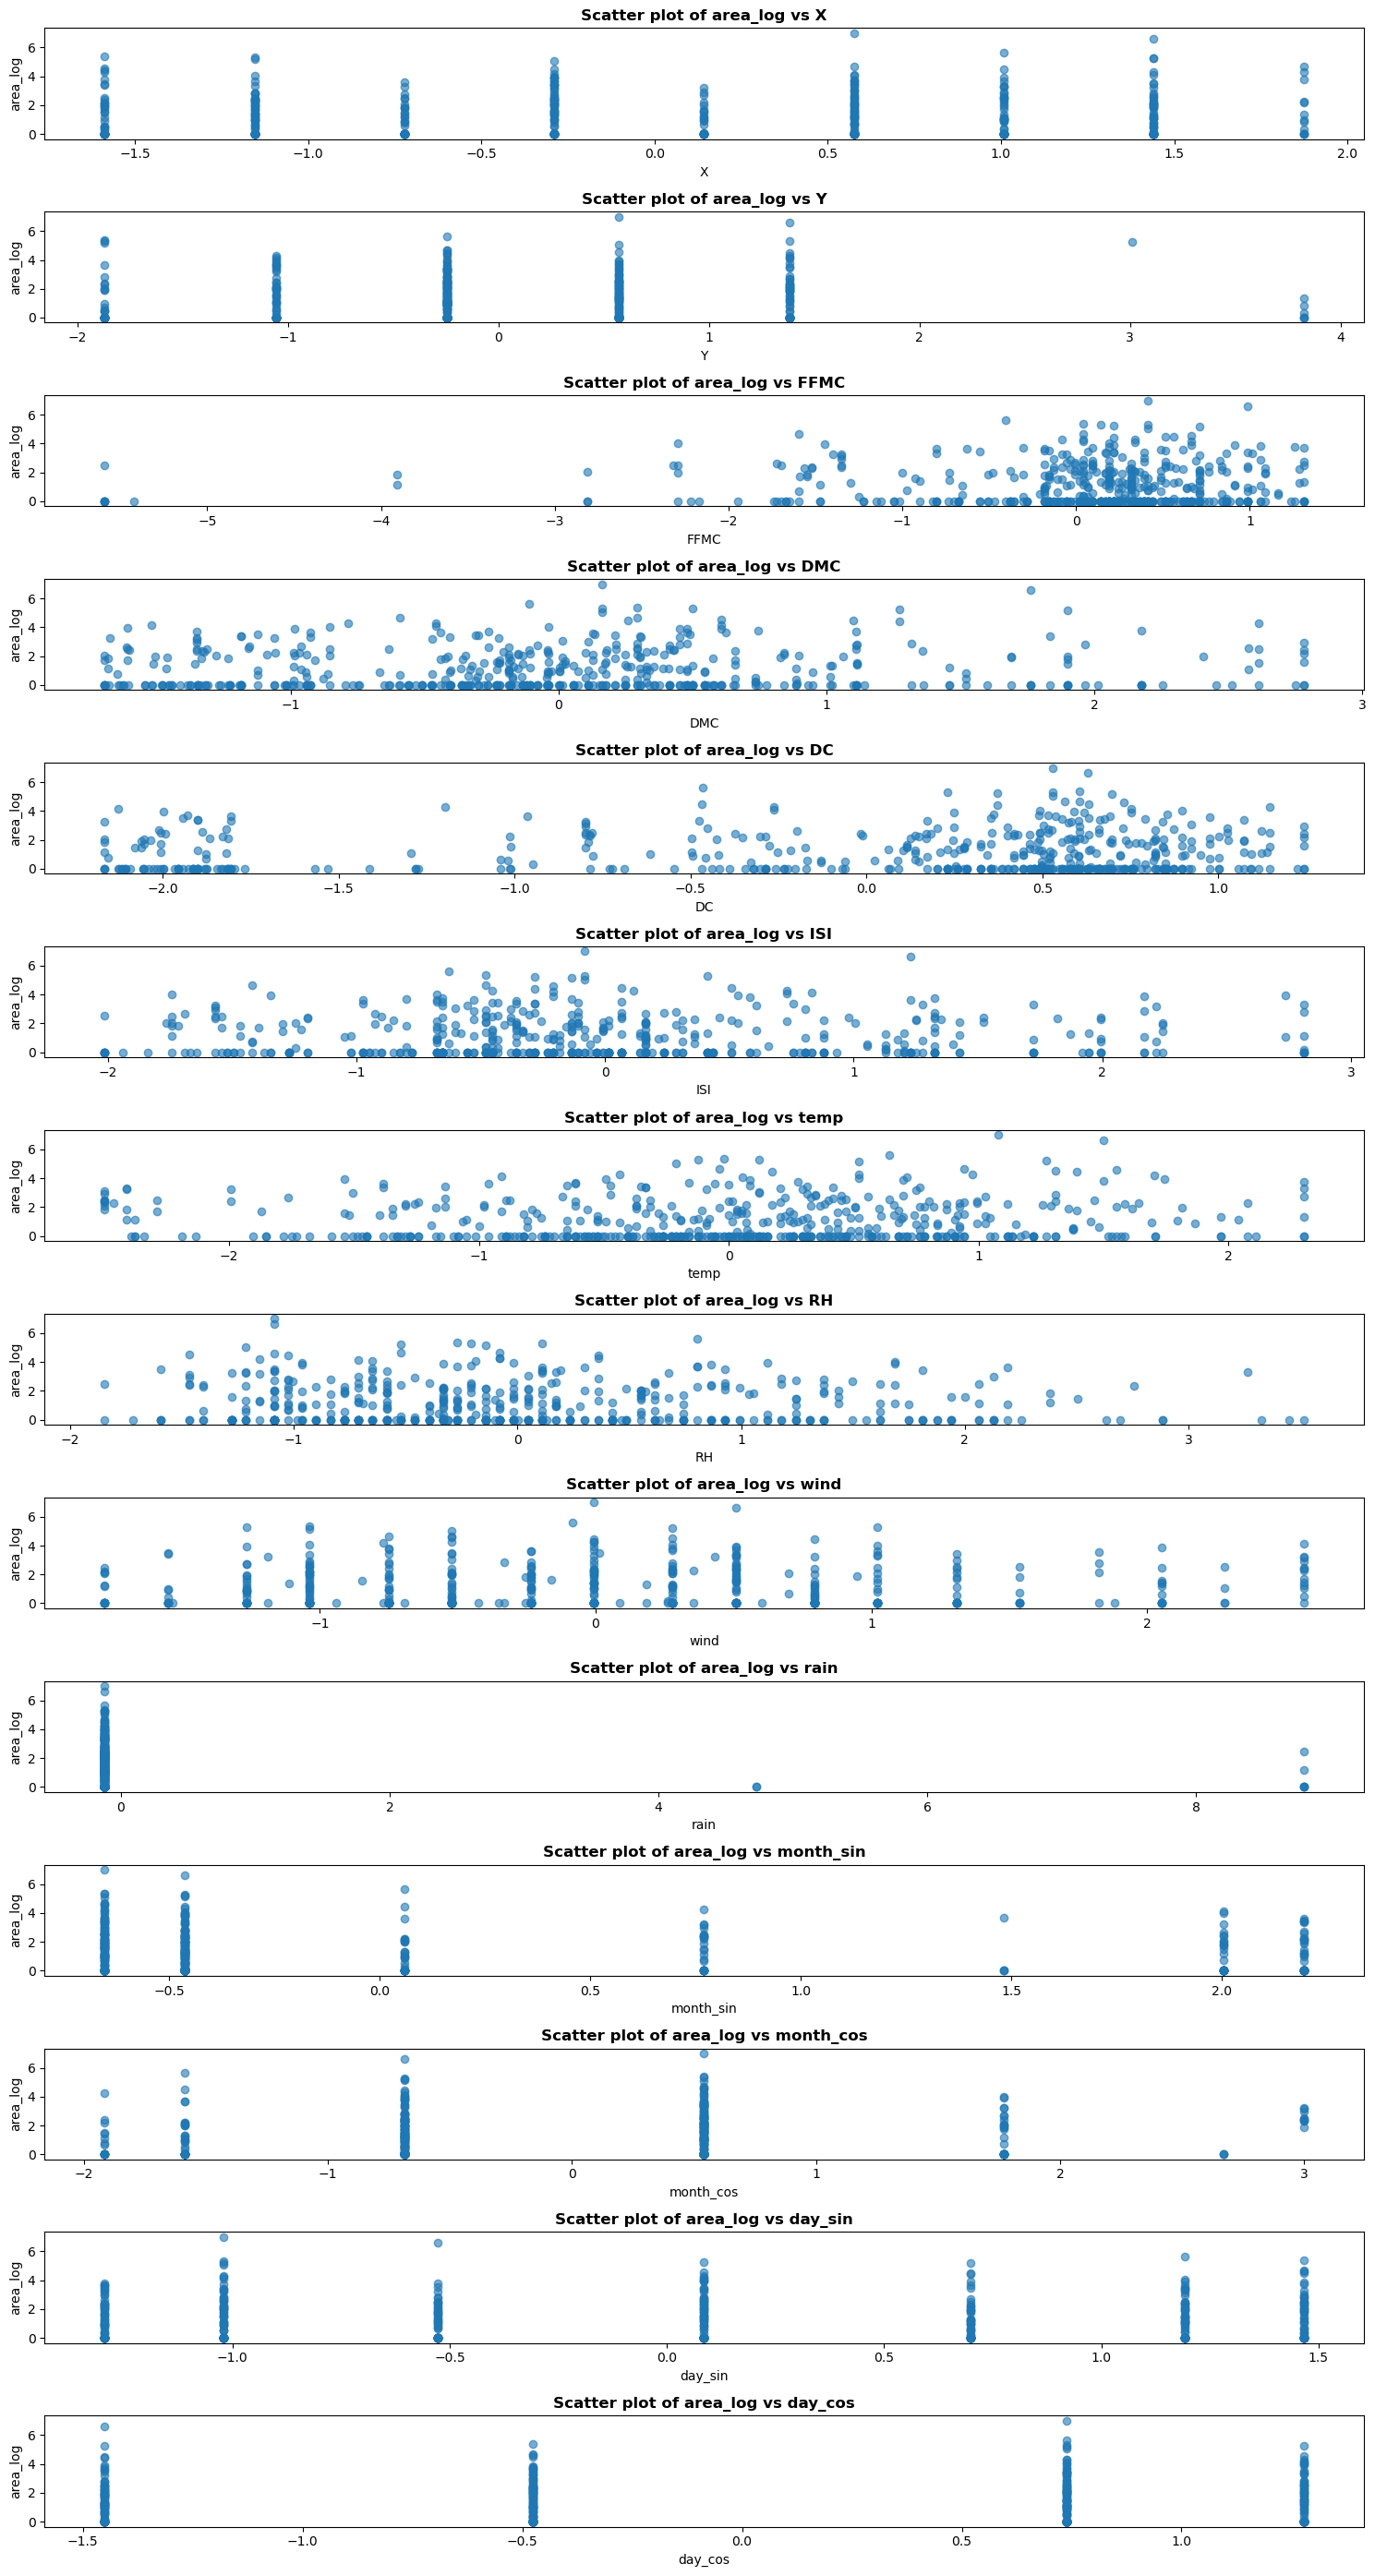

In [23]:
# Visualize new features and new target column
num_cols = len(imputed_df.columns)

fig, axs = plt.subplots(num_cols, figsize=(15, 2* num_cols))

# Loop through each column to create scatter plots with KDE lines
for i, column in enumerate(imputed_df.columns):
    axs[i].scatter(imputed_df[column], fire['area_log'], alpha=0.6)
    axs[i].set_title(f'Scatter plot of area_log vs {column}', weight='bold')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('area_log')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### Brief Interpretation

**Log-Transformed Target (area_log)**

- The target variable `area` has been log-transformed to `area_log`. This transformation reduces the skewness in the data, making the distribution more normalized. As a result, relationships that were previously masked by extreme values or skewness might now become more evident.

**Standardized Features**

- All features have been standardized, meaning they have been rescaled to have a mean of 0 and a standard deviation of 1. This helps in visualizing the relationships more clearly without the bias of different scales.

#### Feature-Specific Comparisons

**X and Y (Spatial Coordinates)**

- After standardization, the scatter plots for `X` and `Y` still show no clear linear relationship with `area_log`. The points are more centered due to standardization, but the scatter remains relatively evenly distributed. This suggests that spatial coordinates alone may not be predictive of fire size.


**Fire Weather Indices (FFMC, DMC, DC, ISI)**

- `FFMC` (Fine Fuel Moisture Code): The scatter plot is more spread out after standardization, but still shows no strong linear trend. There seems to be a slight increase in `area_log` with higher values of standardized FFMC, indicating a potential weak correlation.
- `DMC` (Duff Moisture Code): The plot shows a denser spread of points, but there is no strong linear correlation with `area_log`. Standardization does not significantly change the relationship observed.
- `DC` (Drought Code): There appears to be a slight positive trend after standardization, where higher DC values could be associated with larger burned areas (`area_log`), but the relationship is weak.
- `ISI` (Initial Spread Index): Similar to FFMC, a slight upward trend can be seen in higher standardized ISI values, indicating a possible weak positive correlation with `area_log`.
  
**Weather Features (temp, RH, wind, rain)**

- `temp` (Temperature): The scatter plot after standardization still shows no clear trend with `area_log`. Most of the data points remain clustered in the center.
- `RH` (Relative Humidity): There is a dense spread of points, and the relationship remains unclear. Standardization does not reveal any new patterns.
- `wind` (Wind Speed): Most data points are still concentrated at lower wind speeds, with no clear correlation to `area_log`.
- `rain` (Rainfall): The plot remains sparse, with most points near zero, which makes it difficult to determine any meaningful correlation after standardization.

**Cyclic Features (month_sin, month_cos, day_sin, day_cos)**

- The scatter plots for these features show clusters due to their cyclic nature (encoded with sine and cosine transformations). They appear centered due to standardization but do not reveal any new trends or correlations with `area_log`. These features might still contain useful periodic patterns that are not apparent in scatter plots.
  
#### Comparison with Previous Scatter Plots (Original Features and area):

The log transformation of the target variable (`area_log`) makes the relationship between features and the target more interpretable by reducing the impact of extreme values. Even after preprocessing (log transformation and standardization), there are still no strong linear relationships between the features and `area_log`. The absence of clear linear trends suggests the potential presence of non-linear relationships.

In [24]:
# Drop the original 'area' column and use the transformed one
fire.drop(columns=['area'], inplace=True)

#### Subset Selection

No we'll perform feature selection steps, first we'll start with sequential feature selection.


In [25]:
# Target variable
y = fire['area_log'] 

# Features
X = imputed_df 

In [26]:
# Define feature counts for which to create models and selectors
feature_count = [2, 4, 6, 8]

# Initialize dictionaries to store models
lr_models = {}
sfs_models = {}
direction = ['forward', 'backward']

# Nested loop to create models for each direction and feature count
for d in direction:
    for n in feature_count:
        # Create Linear Regression model and store it in the dictionary
        lr_models[f'lr_model_{n}'] = LinearRegression()
        
        # Create Sequential Feature Selector for each Linear Regression model and store it
        sfs_models[f'{d}_{n}'] = SequentialFeatureSelector(estimator=
                                                              lr_models[f'lr_model_{n}'],  # Use the corresponding Linear Regression model
                                                              n_features_to_select=n,  # Number of features to select
                                                              direction=d  # Direction to select
                                                             )
        sfs_models[f'{d}_{n}'].fit(X, y)
        sfs_models[f'{d}_{n}_features'] = sfs_models[f'{d}_{n}'].get_feature_names_out()

In [27]:
# Check created LR
lr_models

{'lr_model_2': LinearRegression(),
 'lr_model_4': LinearRegression(),
 'lr_model_6': LinearRegression(),
 'lr_model_8': LinearRegression()}

In [28]:
# Check Sequential Feature Selection models and features
sfs_models

{'forward_2': SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=2),
 'forward_2_features': array(['X', 'month_sin'], dtype=object),
 'forward_4': SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=4),
 'forward_4_features': array(['X', 'FFMC', 'rain', 'month_sin'], dtype=object),
 'forward_6': SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=6),
 'forward_6_features': array(['X', 'FFMC', 'RH', 'wind', 'rain', 'month_sin'], dtype=object),
 'forward_8': SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=8),
 'forward_8_features': array(['X', 'FFMC', 'RH', 'wind', 'rain', 'month_sin', 'day_sin',
        'day_cos'], dtype=object),
 'backward_2': SequentialFeatureSelector(direction='backward', estimator=LinearRegression(),
                           n_features_to_select=2),
 'backward_2_features': array(['X', 'DC'], dtype=object),
 'backward_4': SequentialFeatureSelector(direction='bac

In [29]:
# Features of forward selection
print(sfs_models['forward_2_features'])
print(sfs_models['forward_4_features'])
print(sfs_models['forward_6_features'])
print(sfs_models['forward_8_features'])

['X' 'month_sin']
['X' 'FFMC' 'rain' 'month_sin']
['X' 'FFMC' 'RH' 'wind' 'rain' 'month_sin']
['X' 'FFMC' 'RH' 'wind' 'rain' 'month_sin' 'day_sin' 'day_cos']


In [30]:
# Features of backward selection
print(sfs_models['backward_2_features'])
print(sfs_models['backward_4_features'])
print(sfs_models['backward_6_features'])
print(sfs_models['backward_8_features'])

['X' 'DC']
['X' 'FFMC' 'DC' 'rain']
['X' 'FFMC' 'DC' 'RH' 'wind' 'rain']
['X' 'FFMC' 'DC' 'RH' 'wind' 'rain' 'day_sin' 'day_cos']


In [31]:
# Comparison of forward and backward selection
print(sfs_models['forward_2_features'] == sfs_models['backward_2_features'])
print(sfs_models['forward_4_features'] == sfs_models['backward_4_features'])
print(sfs_models['forward_6_features'] == sfs_models['backward_6_features'])
print(sfs_models['forward_8_features'] == sfs_models['backward_8_features'])

[ True False]
[ True  True False False]
[ True  True False False False False]
[ True  True False False False False  True  True]


#### Interpretation of Sequential Feature Analysis

- `X`: Appears in both forward and backward selection models for multiple feature counts, indicating it's an important feature. The consistent selection of X (likely a spatial coordinate) might indicate that certain regions within the studied area have specific characteristics that are more susceptible to fire or that the model is identifying certain geographical patterns.
- `FFMC` (Fine Fuel Moisture Code): Commonly selected, which suggests it has significant predictive power for the target variable.
- `RH` (Relative Humidity): Consistently appears in the selections, highlighting its relevance.
- `wind`: Often selected, indicating that wind speed plays a role in predicting the target variable.
- `rain`: The presence of rain as a selected feature implies it may have a negative or positive effect on the outcome.
  - These weather-related features are crucial, as expected for many models predicting natural phenomena like fires or environmental changes.

- `day_sin` and `day_cos`: These cyclic features, derived from the day, consistently appear, suggesting that seasonality or periodic patterns play an important role. The inclusion of these features indicates that time-based patterns (likely related to weather or other seasonal factors) are relevant.

In [32]:
# Fit linear regression with the forward models features
forward_2_model = LinearRegression().fit(X[sfs_models['forward_2_features']], y)
forward_4_model = LinearRegression().fit(X[sfs_models['forward_4_features']], y)
forward_6_model = LinearRegression().fit(X[sfs_models['forward_6_features']], y)
forward_8_model = LinearRegression().fit(X[sfs_models['forward_8_features']], y)

# Fit linear regression with the backward models features
backward_2_model = LinearRegression().fit(X[sfs_models['backward_2_features']], y)
backward_4_model = LinearRegression().fit(X[sfs_models['backward_4_features']], y)
backward_6_model = LinearRegression().fit(X[sfs_models['backward_6_features']], y)
backward_8_model = LinearRegression().fit(X[sfs_models['backward_8_features']], y)

####  Developing Candidate Models

The models chosen by subset selection are still linear models at heart, and they may not be the best solution to this problem. Despite their widespread utility, some problems have a non-linear component that standard linear regression models can't account for. That extra flexibility comes at a price: an increased chance of `overfitting`. Including higher polynomials, more knots, or many features in the model may help with predictive ability on the training set, but we may be setting ourselves up for poor performance on the test set. In the case of many features, we can also turn to regularization to account for this.

Developing candidate models can be a slow process, but it's worth exploring our options as much as we have time for. Many of these models will perform poorly, but this can also give us insight into how we can iterate on and improve them.

In [33]:
# X is the feature matrix, y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate ridgeCV model
ridge = RidgeCV(alphas=np.linspace(1, 9000, num=1000))

# Use already scaled features and target variable to fit ridgeCV model
ridge.fit(X_train, y_train) 

# Calculate mean squared error for ridgeCV model
ridge_mse = mean_squared_error(y_test, ridge.predict(X_test))

# Print values
print(f'RidgeCV alpha: {ridge.alpha_}')
print(f'RidgeCV coefficients: {ridge.coef_}')
print(f'RidgeCV error: {ridge_mse}')

RidgeCV alpha: 8441.503503503503
RidgeCV coefficients: [ 0.00492863  0.00318617  0.00296843  0.00571796  0.00334454 -0.00044311
  0.00192455 -0.00152079  0.00151682 -0.003246   -0.00339626  0.0037878
  0.00108147  0.00022565]
RidgeCV error: 2.1944901458148385


In [34]:
# Instantiate LassoCV model
lasso = LassoCV(alphas=np.linspace(1, 10000, num=1000))

# Use already scaled features and target variable to fit LassoCV model
lasso.fit(X_train, y_train) 

# Calculate mean squared error for LassoCV model
lasso_mse = mean_squared_error(y_test, lasso.predict(X_test))

# Print values
print(f'LassoCV alpha: {lasso.alpha_}')
print(f'LassoCV coefficients: {lasso.coef_}')
print(f'LassoCV error: {lasso_mse}')

LassoCV alpha: 10000.0
LassoCV coefficients: [ 0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0.  0.  0.  0.]
LassoCV error: 2.1992238175877623


The LASSO tuning parameter tends to select extreme values, likely because the outcome variable has many small values. This suggests that the model favors no features over including any. We'll use a ridge regression and choose not to use a LASSO model here since the regularization results aren't helpful.

#### Going Beyond Linear Models: Spline

In [35]:
# Set pipeline with SplineTransformer and ridgeCV
pipeline = Pipeline([
    ('spline', SplineTransformer()), # Spline
    ('ridge', ridge)  # Our ridgeCV model
])

# Set parameters for GridSearchCV
param_grid = {'spline__n_knots' : [3, 4, 5, 6, 7, 8, 9, 10],
              'spline__degree' : [1, 2, 3]
             }

# Set grid_search model
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           n_jobs=-1, 
                           verbose=1, 
                           scoring='neg_mean_squared_error')

# Fit model with training data
grid_search.fit(X_train, y_train)

# Print best estimator and parameters
print('\n')
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best estimator: {grid_search.best_estimator_}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Best parameters: {'spline__degree': 3, 'spline__n_knots': 10}
Best estimator: Pipeline(steps=[('spline', SplineTransformer(n_knots=10)),
                ('ridge',
                 RidgeCV(alphas=array([1.00000000e+00, 1.00080080e+01, 1.90160160e+01, 2.80240240e+01,
       3.70320320e+01, 4.60400400e+01, 5.50480480e+01, 6.40560561e+01,
       7.30640641e+01, 8.20720721e+01, 9.10800801e+01, 1.00088088e+02,
       1.09096096e+02, 1.18104104e+02, 1.27112112e+02, 1.36120120e+02,
       1.45128128e+02, 1.54136...
       8.79281582e+03, 8.80182382e+03, 8.81083183e+03, 8.81983984e+03,
       8.82884785e+03, 8.83785586e+03, 8.84686386e+03, 8.85587187e+03,
       8.86487988e+03, 8.87388789e+03, 8.88289590e+03, 8.89190390e+03,
       8.90091191e+03, 8.90991992e+03, 8.91892793e+03, 8.92793594e+03,
       8.93694394e+03, 8.94595195e+03, 8.95495996e+03, 8.96396797e+03,
       8.97297598e+03, 8.98198398e+03, 8.99099199e+03, 9.00000000e+0

In [36]:
# Set best model based on estimator
spline_model = grid_search.best_estimator_

# Calculate mean squared error from best model
mse = mean_squared_error(y_test, spline_model.predict(X_test))

# Print mse of spline model
print(f"Spline Model MSE: {mse}")
print(f'RidgeCV Model MSE: {ridge_mse}')

Spline Model MSE: 2.199156037096387
RidgeCV Model MSE: 2.1944901458148385


The difference in MSE between the two models is very small (2.1992 - 2.1949 ≈ 0.0043). This minimal difference suggests that both models are performing similarly on the given dataset. The RidgeCV model is slightly better in terms of MSE, but the difference is not large enough to consider it a significantly better model. 

#### K-fold Cross Validation

Next we'll use k-fold cross-validation to evaluate all of the candidate models. K-fold cross-validation gives us a better idea about model performance on unseen datasets compared to a single train-test split.

In [37]:
# Use cross validation on all candidate models, negative MSE as test score
cv_reference = cross_val_score(reference, X[["wind", "temp"]], y, n_jobs=-1, cv = 5, scoring = "neg_mean_squared_error")
cv_ridge = cross_val_score(ridge, X, y, n_jobs=-1, cv = 5, scoring = "neg_mean_squared_error")
cv_spline = cross_val_score(spline_model, X, y, n_jobs=-1, cv = 5, scoring = "neg_mean_squared_error")
cv_forward2 = cross_val_score(forward_2_model, X[sfs_models['forward_2_features']], y, cv = 5, scoring = "neg_mean_squared_error")
cv_forward4 = cross_val_score(forward_4_model, X[sfs_models['forward_4_features']], y, cv = 5, scoring = "neg_mean_squared_error")
cv_forward6 = cross_val_score(forward_6_model, X[sfs_models['forward_6_features']], y, cv = 5, scoring = "neg_mean_squared_error")
cv_forward8 = cross_val_score(forward_8_model, X[sfs_models['forward_8_features']], y, cv = 5, scoring = "neg_mean_squared_error")
cv_backward2 = cross_val_score(backward_2_model, X[sfs_models['backward_2_features']], y, cv = 5, scoring = "neg_mean_squared_error")
cv_backward4 = cross_val_score(backward_4_model, X[sfs_models['backward_4_features']], y, cv = 5, scoring = "neg_mean_squared_error")
cv_backward6 = cross_val_score(backward_6_model, X[sfs_models['backward_6_features']], y, cv = 5, scoring = "neg_mean_squared_error")
cv_backward8 = cross_val_score(backward_8_model, X[sfs_models['backward_8_features']], y, cv = 5, scoring = "neg_mean_squared_error")

In [38]:
# Print the mean of the MSE and standard deviation per model
print("Reference Model, Avg Test MSE: ", np.mean(cv_reference), " SD: ", np.std(cv_reference))
print("Ridge Model, Avg Test MSE: ", np.mean(cv_ridge), " SD: ", np.std(cv_ridge))
print("Spline Model, Avg Test MSE: ", np.mean(cv_spline), " SD: ", np.std(cv_spline))
print("Forward-2 Model, Avg Test MSE: ", np.mean(cv_forward2), " SD: ", np.std(cv_forward2))
print("Forward-4 Model, Avg Test MSE: ", np.mean(cv_forward4), " SD: ", np.std(cv_forward4))
print("Forward-6 Model, Avg Test MSE: ", np.mean(cv_forward6), " SD: ", np.std(cv_forward6))
print("Forward-8 Model, Avg Test MSE: ", np.mean(cv_forward8), " SD: ", np.std(cv_forward8))
print("Backward-2 Model, Avg Test MSE: ", np.mean(cv_backward2), " SD: ", np.std(cv_backward2))
print("Backward-4 Model, Avg Test MSE: ", np.mean(cv_backward4), " SD: ", np.std(cv_backward4))
print("Backward-6 Model, Avg Test MSE: ", np.mean(cv_backward6), " SD: ", np.std(cv_backward6))
print("Backward-8 Model, Avg Test MSE: ", np.mean(cv_backward8), " SD: ", np.std(cv_backward8))

Reference Model, Avg Test MSE:  -2.204574131246847  SD:  1.0588527569353887
Ridge Model, Avg Test MSE:  -2.3550144848217336  SD:  1.0531286298188502
Spline Model, Avg Test MSE:  -2.3359648154012653  SD:  1.0516048394102948
Forward-2 Model, Avg Test MSE:  -2.162879342976401  SD:  1.0106535034045265
Forward-4 Model, Avg Test MSE:  -2.1727645509349043  SD:  1.0047704316922237
Forward-6 Model, Avg Test MSE:  -2.2009692791214586  SD:  0.9805966225750509
Forward-8 Model, Avg Test MSE:  -2.2195677494968526  SD:  0.97460798270625
Backward-2 Model, Avg Test MSE:  -2.1693409694243044  SD:  1.0220907584485788
Backward-4 Model, Avg Test MSE:  -2.177536515759382  SD:  1.0144733403112676
Backward-6 Model, Avg Test MSE:  -2.198762776457718  SD:  0.9905077965941889
Backward-8 Model, Avg Test MSE:  -2.216976444115496  SD:  0.9829866196315032


#### Final Interpretation of the Results

**Best Performing Model: Forward-2 Selection Model**

Among all candidate models, the Forward-2 selection model (which selects two features using forward feature selection) has the lowest average MSE of -2.16 on the log scale (equivalent to a positive MSE of 2.16). This suggests that, relative to the other models, the Forward-2 model provides the best fit for predicting log_area. However, interpreting this in the context of the original scale tells a different story.

**Implications of Log-Scale MSE**
An MSE of 2.16 on the log scale translates to an RMSE of approximately 1.47 on the log scale. To understand this on the original scale of area. The RMSE on the log scale is:

$$
\text{RMSE}_{\text{log}} = \sqrt{2.16} \approx 1.47
$$

we exponentiate the RMSE:

$$
\text{Error Factor} \approx e^{1.47} \approx 4.35
$$

This means that the predictions are, on average, off by a factor of about 4.35 when converted back to the original scale. This substantial error factor shows that, while the model performs well relative to other models on the log scale, it still does not provide highly accurate predictions for the original area variable.

**General Model Performance**

The fact that the MSE values are on the log scale means that all models are less accurate than they might appear at first glance. An MSE of around 2.16 implies a significant error when considering the original scale, indicating that even the best model (Forward-2) is far from being a reliable predictor.
The models’ performance on the log scale helps to reduce skewness and stabilize variance, but the translation back to the original scale shows that the predictions are still largely inaccurate.

**Comparison of Models**

- Forward-2 Model: This model, with an MSE of 2.16 (log scale), is the best among all tested models, suggesting that using two optimally selected features captures the most essential patterns in the data. However, as noted, the prediction error remains significant when converted back to the original scale.
  
- Backward-2 Model: The Backward-2 model follows closely with an MSE of 2.17 (log scale). This is nearly the same as the Forward-2 model, indicating that both selection methods perform similarly well with two features, though Forward-2 is slightly better.

- Ridge and Spline Models: Both Ridge (MSE = 2.36) and Spline (MSE = 2.34) models have higher MSEs than the feature selection models. This suggests that regularization and spline transformations alone do not lead to better predictive performance for this dataset.

- Reference Model: The Reference Model using only wind and temp features has an MSE of 2.20 (log scale), performing worse than the feature selection models but better than Ridge and Spline. This shows that adding relevant features is more beneficial than simply using regularization or transformations.